In [1]:
import os
import json
import pickle
import xgboost
from base import ModelHelper

%load_ext autoreload
%autoreload 2

In [2]:
model_helper = ModelHelper("./restrict_features", "model_restricted_features")
model_helper

Model Folder = ./restrict_features
Metadata Folder = ./restrict_features/metadata
Path to data = ./raw-data/full_data.gz
Path to test data = ./raw-data/test_labelled.gz
Path to evaluation folder = ./restrict_features/evaluation
Seed = 1

In [3]:
df = model_helper.prepare_data(model_helper.path_to_full_data)
test = model_helper.prepare_data(model_helper.path_to_test_data)

In [4]:
best_weight_features = ["src_bytes", "service", "dst_bytes", "dst_host_srv_count", "dst_host_count",
                        "dst_host_rerror_rate", "dst_host_same_srv_rate", "dst_host_same_src_port_rate",
                        "duration", "dst_host_srv_diff_host_rate"]
best_gain_features = ["same_srv_rate", "flag_RSTR", "prototype_icmp", "wrong_fragment", "srv_serror_rate",
                      "dst_host_srv_serror_rate", "srv_count", "dst_host_serror_rate", "num_compromised",
                      "src_bytes"]
best_cover_features = ["flag_RSTR", "wrong_fragment", "num_failed_logins", "same_srv_rate", "srv_serror_rate",
                       "urgent", "prototype_icmp", "num_compromised", "hot", "diff_srv_rate"]


features_to_keep = {*best_weight_features, *best_gain_features, *best_cover_features}
print(len(features_to_keep))

23


In [5]:
df = df[[col for col in df.columns if col in features_to_keep or col == "target"]]
test = test[[col for col in test.columns if col in features_to_keep or col == "target"]]

In [6]:
X_train = df[[col for col in df.columns if col != 'target']]
y_train = df['target']
X_test = test[[col for col in test.columns if col != 'target']]
y_test = test['target']

In [7]:
xgb_model = xgboost.XGBClassifier(random_state=model_helper.seed)

In [8]:
best_params = model_helper.random_grid_search(
    X_train, y_train,
    model=xgb_model,
    n_iter=25
)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 33.6min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 33.9min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed: 33.9min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 34.1min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 34.3min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 35.8min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 35.8min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 36.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 36.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 36.7min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 37.0min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 37.4min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 55.6min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 55.7min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 5

In [9]:
best_params

{'subsample': 0.5,
 'n_estimators': 50,
 'max_depth': 8,
 'learning_rate': 0.5,
 'gamma': 2.5}

In [10]:
xgb_model = xgboost.XGBClassifier(**best_params, random_state=model_helper.seed)
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.00520	validation_1-error:0.08152
[1]	validation_0-error:0.00136	validation_1-error:0.06165
[2]	validation_0-error:0.00060	validation_1-error:0.06249
[3]	validation_0-error:0.00061	validation_1-error:0.06693
[4]	validation_0-error:0.00050	validation_1-error:0.05651
[5]	validation_0-error:0.00041	validation_1-error:0.05940
[6]	validation_0-error:0.00034	validation_1-error:0.05861
[7]	validation_0-error:0.00030	validation_1-error:0.05851
[8]	validation_0-error:0.00027	validation_1-error:0.05654
[9]	validation_0-error:0.00022	validation_1-error:0.05944
[10]	validation_0-error:0.00022	validation_1-error:0.05601
[11]	validation_0-error:0.00021	validation_1-error:0.05118
[12]	validation_0-error:0.00019	validation_1-error:0.05400
[13]	validation_0-error:0.00016	validation_1-error:0.05376
[14]	validation_0-error:0.00014	validation_1-error:0.05161
[15]	validation_0-error:0.00014	validation_1-error:0.05356
[16]	validation_0-error:0.00013	validation_1-error:0.05363
[17]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=2.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=0, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [11]:
model_helper.model = xgb_model
model_helper.save_model()

              precision    recall  f1-score   support

      normal       0.92      0.99      0.96     47913
      attack       0.99      0.86      0.92     29378

    accuracy                           0.94     77291
   macro avg       0.95      0.93      0.94     77291
weighted avg       0.95      0.94      0.94     77291



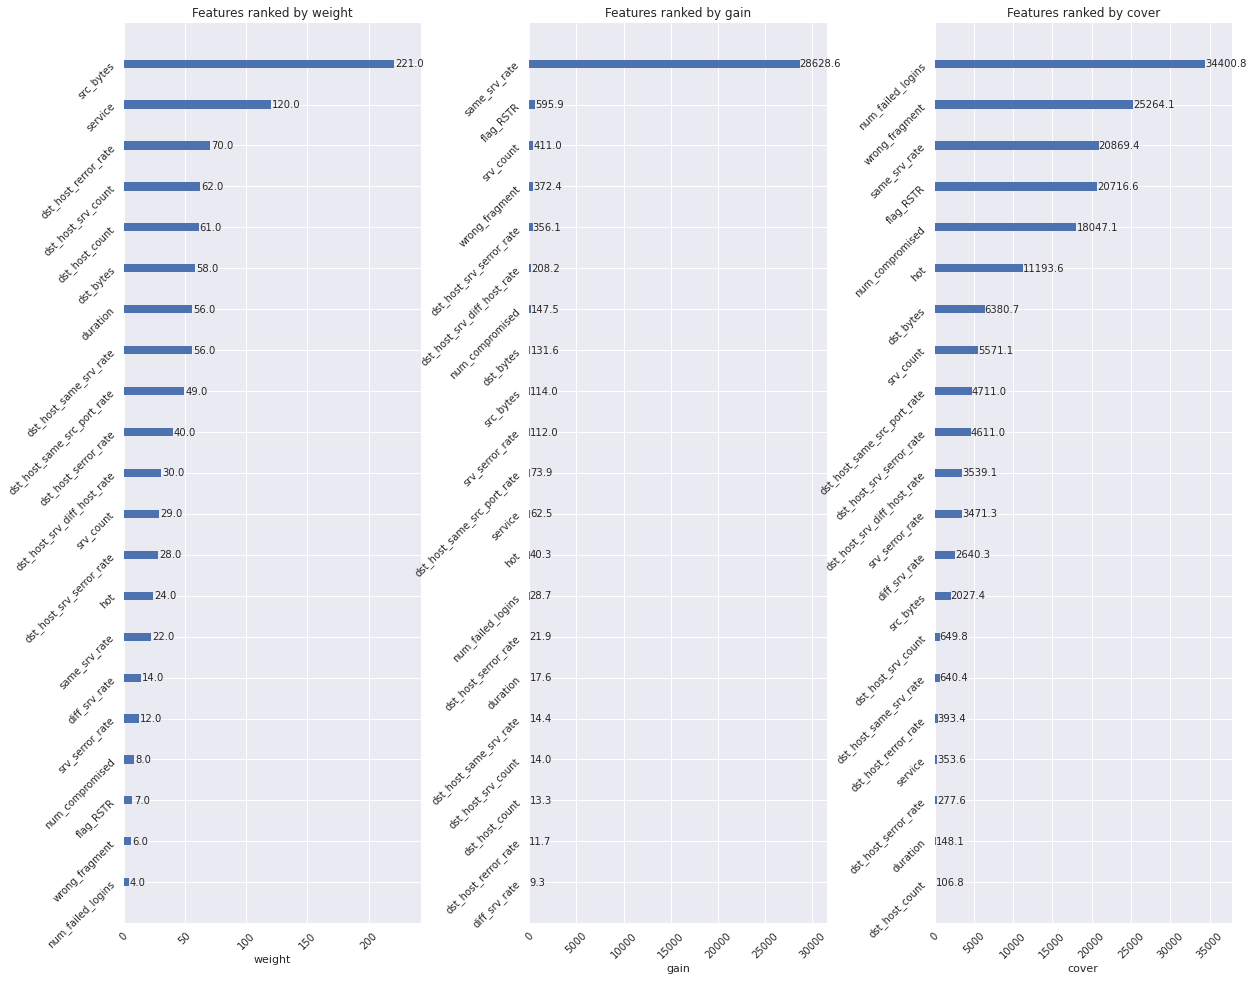

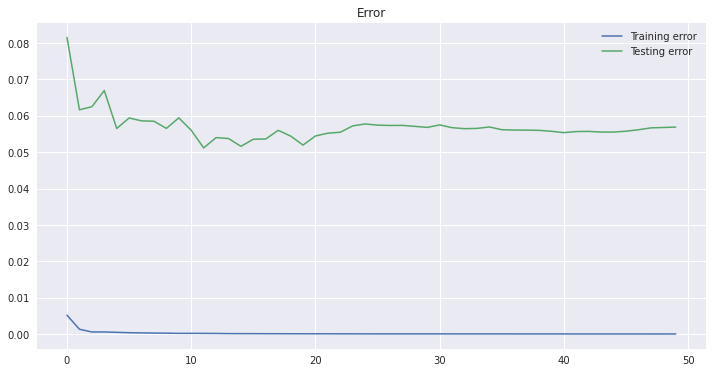

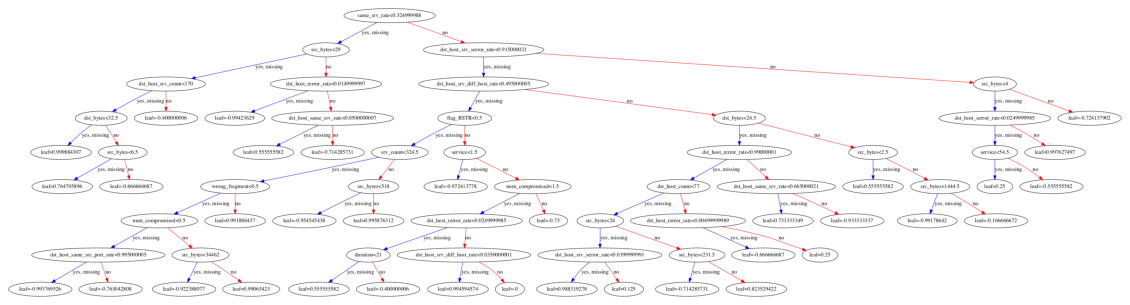

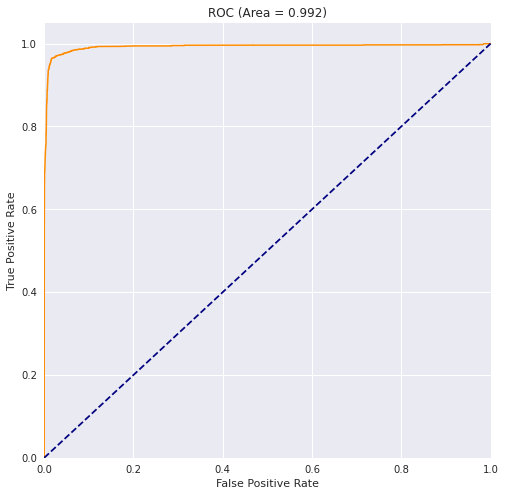

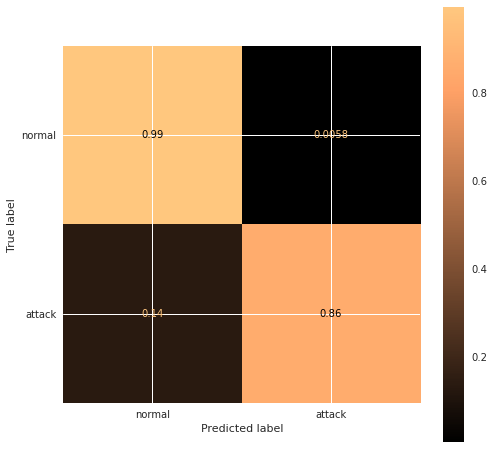

In [12]:
evaluation = model_helper.evaluate_model(X_test, y_test)

In [13]:
evaluation

{'accuracy': 0.9430981614935762,
 'balanced_accuracy': 0.8539831560413418,
 'prfs': {'precision': {'normal': 0.9204266584220595,
   'attack': 0.9890368050117463},
  'recall': {'normal': 0.9941560745517918, 'attack': 0.85982708148955},
  'f1_score': {'normal': 0.9558717290094719, 'attack': 0.9199169671146072},
  'support': {'normal': 47913.0, 'attack': 29378.0}},
 'test_target_proportions': {False: 0.6199039991719605,
  True: 0.38009600082803946},
 'model_params': {'objective': 'binary:logistic',
  'base_score': 0.5,
  'booster': 'gbtree',
  'colsample_bylevel': 1,
  'colsample_bynode': 1,
  'colsample_bytree': 1,
  'gamma': 2.5,
  'gpu_id': -1,
  'importance_type': 'gain',
  'interaction_constraints': '',
  'learning_rate': 0.5,
  'max_delta_step': 0,
  'max_depth': 8,
  'min_child_weight': 1,
  'missing': nan,
  'monotone_constraints': '()',
  'n_estimators': 50,
  'n_jobs': 0,
  'num_parallel_tree': 1,
  'random_state': 1,
  'reg_alpha': 0,
  'reg_lambda': 1,
  'scale_pos_weight': 1,